In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

import pickle

from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor

from matplotlib.font_manager import FontProperties
fp2 = FontProperties(fname=r"../../fonts/Font Awesome 5 Free-Solid-900.otf")

setting environment variables properly now done.


In [3]:
dp = DataPreprocessor(drop_HS=True)
data = dp.preprocess_data("double_entry_final.csv", last_day="2020-05-30", schools_unis="lol")

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Screen/Quarantine
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Travel Bans
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Transport Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Internal Movement Limited
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Public Information Campaigns
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Dropping Symptomatic Testing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Georgia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
IN

In [4]:
data.mask_reopenings()

Masking AL from 2020-04-30 00:00:00+00:00
Masking AD from 2020-05-21 00:00:00+00:00
Masking AT from 2020-05-04 00:00:00+00:00
Masking AT from 2020-05-21 00:00:00+00:00
Masking BE from 2020-05-14 00:00:00+00:00
Masking BA from 2020-05-17 00:00:00+00:00
Masking BG from 2020-05-04 00:00:00+00:00
Masking BG from 2020-05-21 00:00:00+00:00
Masking HR from 2020-04-30 00:00:00+00:00
Masking HR from 2020-05-14 00:00:00+00:00
Masking HR from 2020-05-29 00:00:00+00:00
Masking CZ from 2020-04-27 00:00:00+00:00
Masking CZ from 2020-05-14 00:00:00+00:00
Masking CZ from 2020-05-28 00:00:00+00:00
Masking DK from 2020-04-23 00:00:00+00:00
Masking DK from 2020-05-14 00:00:00+00:00
Masking FI from 2020-05-17 00:00:00+00:00
Masking FR from 2020-05-14 00:00:00+00:00
Masking GE from 2020-05-26 00:00:00+00:00
Masking GE from 2020-05-27 00:00:00+00:00
Masking DE from 2020-04-23 00:00:00+00:00
Masking DE from 2020-05-07 00:00:00+00:00
Masking DE from 2020-05-09 00:00:00+00:00
Masking GR from 2020-05-07 00:00:0

In [5]:
trace = pickle.load(open("alt_masks.pkl", "rb"))

INFO (theano.gof.compilelock): Waiting for existing lock by process '1794' (I am process '1826')
INFO:theano.gof.compilelock:Waiting for existing lock by process '1794' (I am process '1826')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/mrinank/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.3-64/lock_dir
INFO:theano.gof.compilelock:To manually release the lock, delete /Users/mrinank/.theano/compiledir_macOS-10.15.4-x86_64-i386-64bit-i386-3.8.3-64/lock_dir


In [6]:
from matplotlib.gridspec import GridSpec

derived_features = [ #()"Healthcare Infection Control", [0]),
 ("Mask-wearing mandatory in\n(some) public spaces", [0]),
 ("Gatherings limited to\n1000 people or less", [1]),
 ("Gatherings limited to\n100 people or less", [2, 1]),
 ("Gatherings limited to\n10 people or less", [3, 2, 1]),
 ("Some businesses\nclosed", [4]),
 ("Most nonessential\nbusinesses closed", [4, 5]),
 ("Schools and universities\nclosed", [6, 7]),
 ("Stay-at-home order\n(with exemptions)", [8]),  
 ]

cm_plot_style = [
#             ("\uf7f2", "tab:red"), # hospital symbol
            ("\uf963", "black"), # mask
            ("\uf0c0", "darkgrey"), # ppl
            ("\uf0c0", "dimgrey"), # ppl
            ("\uf0c0", "black"), # ppl
            ("\uf07a", "tab:orange"), # shop 1
            ("\uf07a", "tab:red"), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black") # home
]

features = [x for x, _ in derived_features]

res = trace.CMReduction
nS, _ = res.shape
nF = len(derived_features)

derived_res = np.zeros((nS, nF))


for f_i, (f, prodrows) in enumerate(derived_features):
    samples = np.ones(nS)
    for r in prodrows:
        samples = samples * res[:, r] 
    derived_res[:, f_i] = samples

derived_res = 100*(1-derived_res)

def produce_ranges(trace):
    means = np.mean(trace, axis=0)
    med = np.median(trace, axis=0)
    li = np.percentile(trace, 2.5, axis=0)
    ui = np.percentile(trace, 97.5, axis=0)
    lq = np.percentile(trace, 25, axis=0)
    uq = np.percentile(trace, 75, axis=0)
    return means, med, li, ui, lq, uq


mn, med, li, ui, lq, uq = produce_ranges(derived_res)

N_cms = mn.size

fig = plt.figure(figsize=(5.5, 6), dpi=300)

gs = GridSpec(3, 2, figure=fig)
ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=2, rowspan=2))

plt.plot([0, 0], [1, -(N_cms)], "--r", linewidth=0.5)
y_vals = -1 * np.arange(N_cms)

xrange = np.array([-100, 100])
for height in range(0, nF+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
    
plt.scatter(med, y_vals, marker="|", color="black", s=55)

for cm in range(N_cms):
    plt.plot([li[cm], ui[cm]], [y_vals[cm], y_vals[cm]], "black", alpha=0.25, linewidth=3)
    plt.plot([lq[cm], uq[cm]], [y_vals[cm], y_vals[cm]], "black", alpha=0.75, linewidth=3)

x_min = -100
x_max = 100
plt.xlim([x_min, x_max])
xtick_vals = np.arange(-100, 150, 50)
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.ylim([-(N_cms - 0.5), 0.5])

x_r = np.abs(x_min - x_max)
for cm in range(N_cms):
    for i, val in enumerate(derived_features[cm][1]):
        if val < len(cm_plot_style):
            col = cm_plot_style[val][1]
        else:
            col = "k"
        plt.text(x_min - 10.5 - 12.5*i, -cm, cm_plot_style[val][0], horizontalalignment='center', verticalalignment='center',
                     fontproperties=fp2, fontsize=10, color=col)

ax = plt.gca()
plt.yticks(-np.arange(N_cms), [f"{f[0]}" for f in derived_features], fontsize=8, ha="left")
yax = ax.get_yaxis()
yax.set_tick_params(pad=120)

for i, (ticklabel, tickloc) in enumerate(zip(ax.get_yticklabels(), ax.get_yticks())):
    if i < len(cm_plot_style):
            col = cm_plot_style[i][1]
    else:
        col = "k"
    ticklabel.set_color(col)

plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlabel("Average additional reduction in $R$, in the context of our data", fontsize=8)
sns.despine()

ax1 = plt.subplot(gs.new_subplotspec((2, 0), colspan=1, rowspan=1))
data.coactivation_plot(cm_plot_style, newfig=False, skip_yticks=True,)

ax1 = plt.subplot(gs.new_subplotspec((2, 1), colspan=1, rowspan=1))
data.cumulative_days_plot(cm_plot_style, skip_yticks=True, newfig=False)

plt.tight_layout()
plt.savefig("FigureEF.pdf", bbox_inches="tight")

# Pareto Graphs

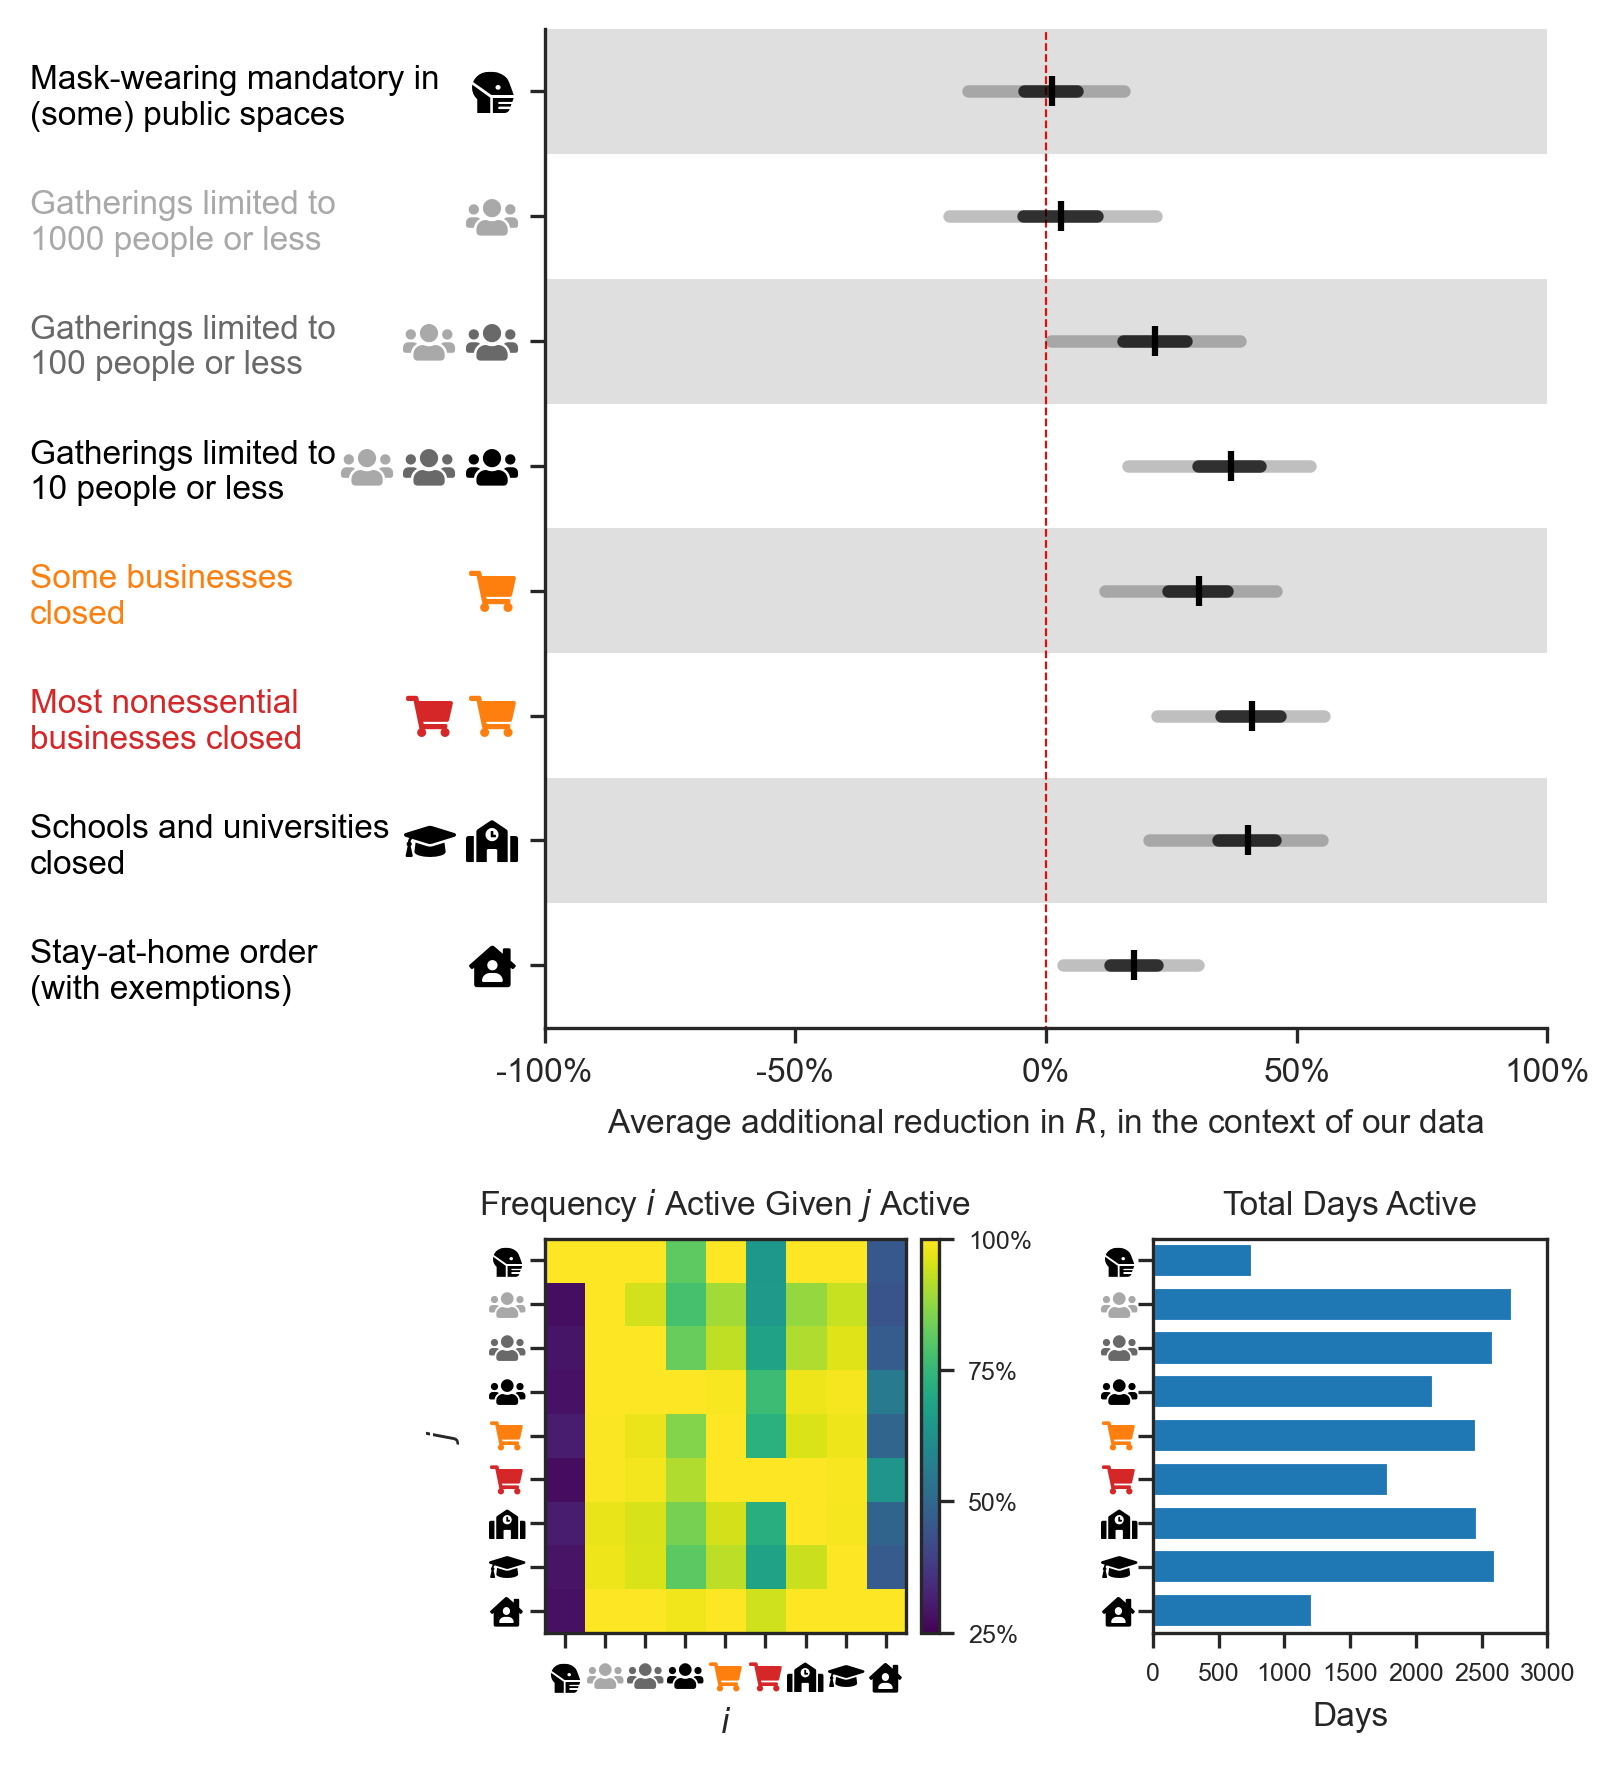

In [7]:
schools_index = data.CMs.index("School Closure")
uni_index = data.CMs.index("University Closure")

In [8]:
stk = np.hstack([data.ActiveCMs[r, :, :] for r in range(len(data.Rs))])
unique_columns, counts = np.unique(stk, return_counts = True, axis=1)
nCMs, nPkgs = unique_columns.shape
n_active = np.zeros(nPkgs)
for p in range(nPkgs):
    n_active[p] = np.sum(unique_columns[:, p])
    if unique_columns[schools_index, p] == 1 and unique_columns[uni_index, p] == 0:
        counts[p] = 0
    
    if unique_columns[schools_index, p] == 0 and unique_columns[uni_index, p] == 1:
        counts[p] = 0

In [9]:
display_together = [None, 2, 3, None, 5, None, None, None,None]

In [10]:
for d, dt in zip(data.CMs, display_together):
    print(d)
    if dt is not None:
        print(f"  with {data.CMs[dt]}")

Mask Wearing
Gatherings <1000
  with Gatherings <100
Gatherings <100
  with Gatherings <10
Gatherings <10
Some Businesses Suspended
  with Most Businesses Suspended
Most Businesses Suspended
School Closure
University Closure
Stay Home Order


In [11]:
def traverse(cm_i, pkg):
    dt = display_together[cm_i]
    
    if dt == None:
        return 0
    elif pkg[dt] == 0: 
        return 0
    elif pkg[dt] == 1:
        return 1 + traverse(dt, pkg)
    
    
def effective_active(pkg):
    n_active = 0
    for cm_i, cm in enumerate(pkg):
        if cm == 1:
            if traverse(cm_i, pkg) == 0:
                n_active += 1
    return n_active

In [12]:
import seaborn as sns
sns.set_style("ticks")
colors = sns.color_palette()

fig = plt.figure(figsize=(10,4), dpi=500)

plt.subplot(121)
for p in range(nPkgs):
    pkg = unique_columns[:, p]
    count_p = counts[p]
    n_active_p = int(np.sum(pkg))
    display_mc = 1
    if np.sum(count_p < counts[n_active == n_active_p]) < display_mc:
        if n_active_p > 0:
            
            if n_active_p == 1:
                marker_size = 100*2
                text_size = 8
                r = 0.2
            elif n_active_p < 4:
                marker_size = 300*2
                text_size = 8
                r = 0.22
            elif n_active_p < 7:
                marker_size = 350*2
                text_size = 7.5
                r = 0.26
            else:
                marker_size = 400*2
                text_size = 7
                r = 0.26
            
            vals = np.ones(nS)
            for c_i in range(nCMs):
                if pkg[c_i] != 0:
                    vals = vals * trace.CMReduction[:, c_i]
            R_vals = 0.999/vals
            
            plt.scatter(n_active_p, np.median(R_vals), color="black", facecolor="white", s=marker_size, zorder=0, linewidth=0.5)
            plt.plot([n_active_p, n_active_p], [np.percentile(R_vals, 2.5), np.percentile(R_vals, 97.5)], zorder=-1, color="lightgray", linewidth=28)
            plt.plot([n_active_p, n_active_p], [np.percentile(R_vals, 25), np.percentile(R_vals, 75)], zorder=-1, color="gray", linewidth=28)
            plt.plot([n_active_p-0.475, n_active_p+0.475], [np.percentile(R_vals, 50), np.percentile(R_vals, 50)], zorder=-3, color="black", linewidth=2)
            
            if n_active_p > 1:
                points = [(np.cos(2*np.pi/n_active_p*x -np.pi/2)*r,np.sin((2*np.pi/n_active_p*x) -np.pi/2)*r) for x in range(0,n_active_p+1)]
                for c_i, c in enumerate(np.nonzero(pkg)[0].tolist()): 
                    plt.text(n_active_p + points[c_i][0], np.median(R_vals) + points[c_i][1], cm_plot_style[c][0], zorder=2, color=cm_plot_style[c][1], fontproperties=fp2, ha="center", va="center", size=text_size)
            else:
                nz = np.nonzero(pkg)[0].tolist()[0]
                plt.text(n_active_p , np.median(R_vals), cm_plot_style[nz][0], zorder=2, color=cm_plot_style[nz][1], fontproperties=fp2, ha="center", va="center", size=text_size)

plt.xlabel("Number NPIs Active", fontsize=12)
plt.ylabel("Maximum $R_0$\nthat can be brought below 1", fontsize=12)
plt.xticks(np.arange(1, 10), fontsize=10)
plt.yticks(fontsize=10)
plt.ylim([0, 9])
plt.xlim([0, 9.5])

plt.subplot(122)
for p in range(nPkgs):
    pkg = unique_columns[:, p]
    count_p = counts[p]
    n_active_p = int(np.sum(pkg))
    if np.sum(count_p < counts[n_active == n_active_p]) < display_mc:
        if n_active_p > 0:
            
            if n_active_p == 1:
                marker_size = 100*2
                text_size = 8
                r = 0.2
            elif n_active_p < 4:
                marker_size = 300*2
                text_size = 8
                r = 0.22
            elif n_active_p < 7:
                marker_size = 350*2
                text_size = 7.5
                r = 0.26
            else:
                marker_size = 400*2
                text_size = 7
                r = 0.26
            
            vals = np.ones(nS)
            for c_i in range(nCMs):
                if pkg[c_i] != 0:
                    vals = vals * trace.CMReduction[:, c_i]
            R_vals = 3.8 * vals
            
            plt.scatter(n_active_p, np.median(R_vals), color="black", facecolor="white", s=marker_size, zorder=0, linewidth=0.5)
            plt.plot([n_active_p, n_active_p], [np.percentile(R_vals, 2.5), np.percentile(R_vals, 97.5)], zorder=-1, color="lightgray", linewidth=10*3)
            plt.plot([n_active_p, n_active_p], [np.percentile(R_vals, 25), np.percentile(R_vals, 75)], zorder=-1, color="gray", linewidth=10*3) 
            plt.plot([n_active_p-0.475, n_active_p+0.475], [np.percentile(R_vals, 50), np.percentile(R_vals, 50)], zorder=-3, color="black", linewidth=2)
            
            
            if n_active_p > 1:
                points = [(np.cos(2*np.pi/n_active_p*x -np.pi/2)*r,np.sin((2*np.pi/n_active_p*x) -np.pi/2)*r*0.6) for x in range(0,n_active_p+1)]
                for c_i, c in enumerate(np.nonzero(pkg)[0].tolist()): 
                    plt.text(n_active_p + points[c_i][0], np.median(R_vals) + points[c_i][1], cm_plot_style[c][0], zorder=2, color=cm_plot_style[c][1], fontproperties=fp2, ha="center", va="center", size=text_size)
            else:
                nz = np.nonzero(pkg)[0].tolist()[0]
                plt.text(n_active_p , np.median(R_vals), cm_plot_style[nz][0], zorder=2, color=cm_plot_style[nz][1], fontproperties=fp2, ha="center", va="center", size=text_size)
plt.ylim([0, 5])
plt.xlim([0, 9.5])
plt.plot([-1, 10], [1, 1], "--", linewidth=1, color="tab:red", zorder=-5)
plt.xlabel("Number NPIs Active", fontsize=12)
plt.ylabel("Resulting $R$ if $R_0=3.8$", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine()
plt.tight_layout()

cms = ["Mask Wearing", "Gatherings <1000", "Gatherings <100", "Gatherings <10", "Some Businesses\nSuspended", "Most Businesses\nSuspended", "School Closure", "University Closure", "Stay Home Order\n(with exemptions)"]
for indx, f in enumerate(data.CMs):
    fig.text(-0.015 + 0.1 + 0.195 * (indx%5), -0.05 * np.floor((indx/5)) , cm_plot_style[indx][0], fontproperties=fp2,  color=cm_plot_style[indx][1], size=9, va="center", ha="left", clip_on=True, zorder=1)
    fig.text(-0.015 + 0.12 + 0.195 * (indx%5), -0.00008 + -0.05 * np.floor((indx/5)), cms[indx], size=8, va="center", ha="left")

plt.savefig(f"FigurePR.svg", bbox_inches='tight')

# Numerical Values

Mask-wearing mandatory in
(some) public spaces
  0.755% [-15.481 ... 1.117 ... 15.559] std: 7.959% Credence Positive: 55.600%
Gatherings limited to
1000 people or less
  2.582% [-19.432 ... 2.995 ... 21.942] std: 10.696% Credence Positive: 60.938%
Gatherings limited to
100 people or less
  21.345% [0.988 ... 21.787 ... 38.784] std: 9.550% Credence Positive: 98.025%
Gatherings limited to
10 people or less
  36.180% [16.278 ... 36.887 ... 52.737] std: 9.309% Credence Positive: 99.925%
Some businesses
closed
  29.947% [11.712 ... 30.522 ... 45.850] std: 8.744% Credence Positive: 99.862%
Most nonessential
businesses closed
  40.489% [22.138 ... 41.078 ... 55.481] std: 8.590% Credence Positive: 100.000%
Schools and universities
closed
  39.652% [20.640 ... 40.205 ... 54.965] std: 8.701% Credence Positive: 99.975%
Stay-at-home order
(with exemptions)
  17.384% [3.302 ... 17.550 ... 30.421] std: 6.954% Credence Positive: 99.150%


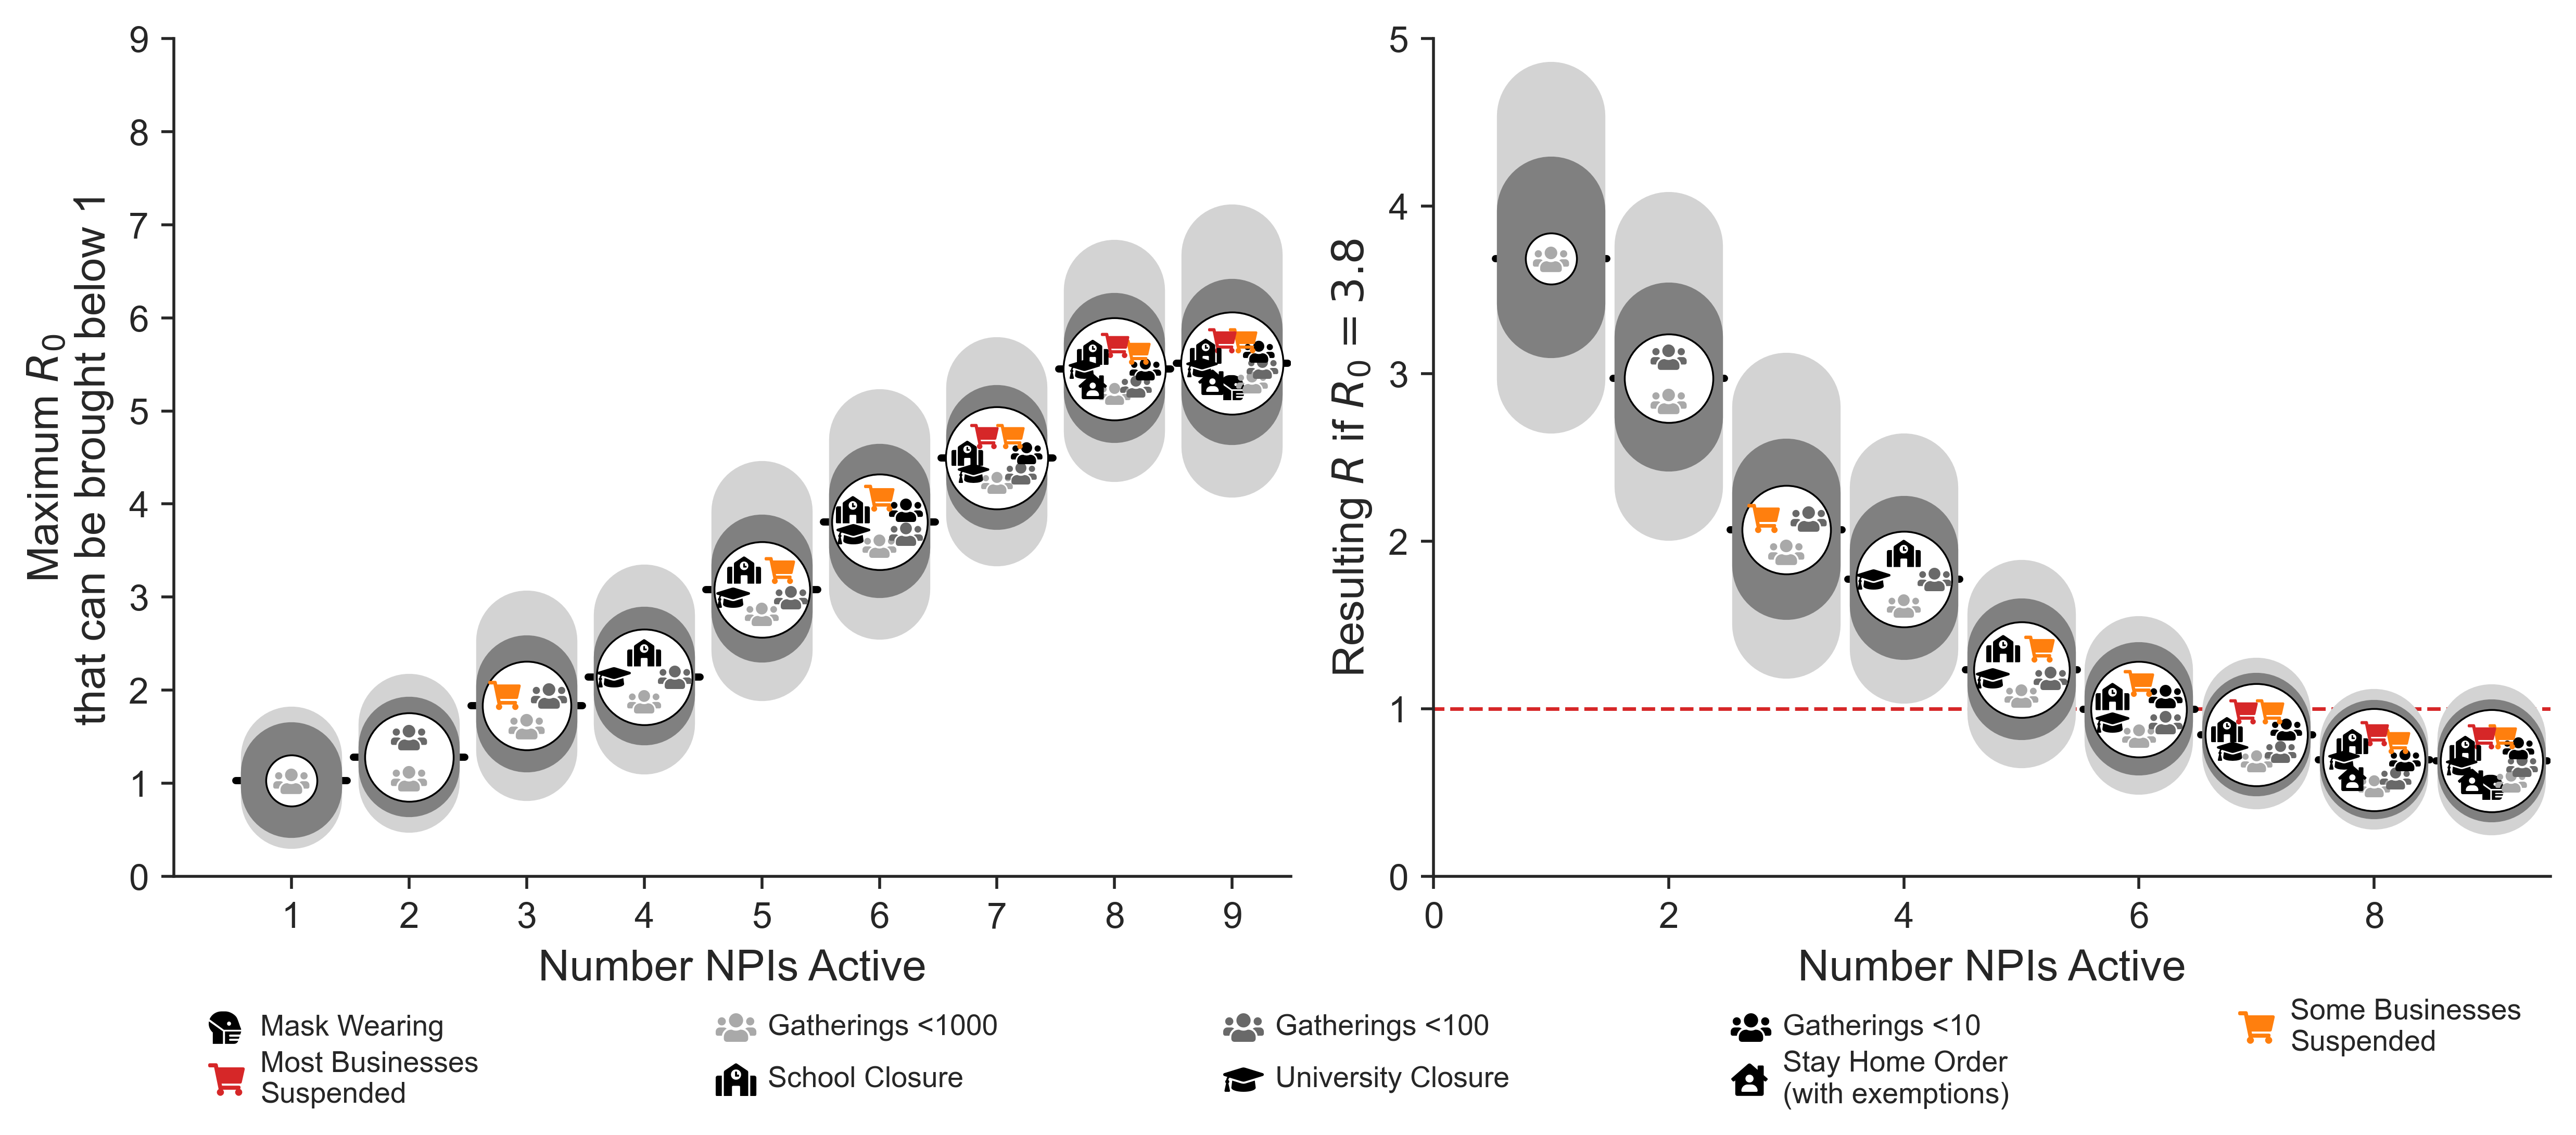

In [13]:
for cm_i, cm in enumerate(derived_features):
    print(f"{cm[0]}")
    print(f"  {np.mean(derived_res[:, cm_i]):.3f}% [{np.percentile(derived_res[:, cm_i], 2.5):.3f} ... {np.percentile(derived_res[:, cm_i], 50):.3f} ... {np.percentile(derived_res[:, cm_i], 97.5):.3f}] std: {np.std(derived_res[:, cm_i]):.3f}% Credence Positive: {100 * np.mean(derived_res[:, cm_i] > 0):.3f}%")

# Additive Effects Table

In [ ]:
print(f"R_0: {np.mean(trace.RegionR):.2f} [{np.percentile(trace.RegionR, 2.5):.2f} ... {np.percentile(trace.RegionR, 50):.2f} ...  {np.percentile(trace.RegionR, 97.5):.2f}]")

In [ ]:
data.mask_reopenings()

In [ ]:
trace.ExpectedLogR.shape

In [ ]:
derived_features = [ #()"Healthcare Infection Control", [0]),
 ("Mask Wearing Mandatory in\n(Some) Public Spaces", [0]),
 ("Gatherings <1000", [1]),
 ("Gatherings <100", [2, 1]),
 ("Gatherings <10", [3, 2, 1]),
 ("Some Businesses\nSuspended", [4]),
 ("Most Businesses\nSuspended", [4, 5]),
 ("School and University\nClosure", [6, 7]),
 ("Stay Home Order\n(with exemptions)", [8]),  
 ]

In [ ]:
rs = [[] for _ in derived_features]

In [ ]:
for r_i in range(len(data.Rs)):
    for d_i in range(len(data.Ds)):
        for p_i in range(len(derived_features)):
            if np.all(data.ActiveCMs[r_i, derived_features[p_i][1], d_i] == 1) and data.NewCases.mask[r_i, d_i] == False:
                rs[p_i].append(np.exp(trace.ExpectedLogR[:, r_i, d_i]))

In [ ]:
for i, (f, _) in enumerate(derived_features):
    rs_active = np.array(rs[i]) 
    rs_active_ex = (np.array(rs[i]) / (1-derived_res[:, i]/100)) - np.array(rs[i]) 
    print(f)
    print(f"Average R when active: {np.mean(rs_active):.2f} [{np.percentile(rs_active, 2.5):.2f} ... {np.percentile(rs_active, 97.5):.2f}]")
    print(f"Average Reduction in R: {np.mean(rs_active_ex):.2f} [{np.percentile(rs_active_ex, 2.5):.2f} ... {np.percentile(rs_active_ex, 97.5):.2f}]")

# Region Rs

In [ ]:
for r_i, r in enumerate(data.Rs):
    print(f"{r}: R_0 = {np.mean(trace.RegionR[:, r_i]):.2f} [{np.percentile(trace.RegionR[:, r_i], 2.5):.2f} ... {np.percentile(trace.RegionR[:, r_i], 97.5):.2f}]")

# Correlation Plot

In [ ]:
res = trace.CMReduction[:, [0, 1, 2, 3, 4, 5, 6, 8]]
res[:, 6] = trace.CMReduction[:, 7] * res[:, 6]

cms = ["Mask-wearing", "Gatherings <1000", "Gatherings <100", "Gatherings <10", "Some businesses closed", "Most businesses closed", "Schools and univeristies closed", "Stay-at-home order"]

In [ ]:
fig = plt.figure(figsize=(4, 3), dpi=300)
correlation = np.corrcoef(res, rowvar=False)
plt.imshow(correlation, cmap="PuOr", vmin=-1, vmax=1)
cbr = plt.colorbar()
cbr.ax.tick_params(labelsize=6)
plt.yticks(np.arange(N_cms), cms, fontsize=6)
plt.xticks(np.arange(N_cms), cms, fontsize=6, rotation=-30, ha="left")
plt.title("Posterior Correlation", fontsize=10);

plt.savefig(f"FigureCorr.pdf", bbox_inches='tight')

In [ ]:
np.min(correlation)

# diagonostic plots

In [ ]:
import arviz as az

In [ ]:
ess = az.ess(trace)

In [ ]:
rhat = az.rhat(trace)

In [ ]:
def collate(stat):
    stat_all = []
    stat_nums = []
    for var in ["CMReduction", "InfectedDeaths", "InfectedCases", "GrowthCases", "GrowthDeaths", "ExpectedLogR", "RegionR", "HyperRVar", "InitialSizeCases_log", "InitialSizeDeaths_log", "RegionLogR_noise", "GrowthCasesNoise", "GrowthDeathsNoise", "Phi_1"]:
        if stat[str(var)].size>1:
            stat_all.append(stat[str(var)].to_dataframe().to_numpy().flatten())
        else:
            stat_nums.append(float(stat[str(var)]))
    stat_all = np.concatenate(np.array(stat_all))
    stat_all = np.concatenate([stat_all, stat_nums])
    stat_all[stat_all > 100] = 1
    return stat_all

In [ ]:
plt.figure(figsize=(7, 3), dpi=300)
plt.subplot(121)
plt.hist(collate(rhat), bins=40)
plt.title("$\hat{R}$", fontsize=12)

plt.subplot(122)
plt.hist(collate(ess), bins=40)
plt.xlim([0, 2])
plt.title("ESS", fontsize=12)
plt.savefig(f"FigureMCMCStats.pdf", bbox_inches='tight')

In [ ]:
ess

In [ ]:
np.mean(trace.Phi_1)

# Model Fit Graphs

In [ ]:
def epicurve_plot(region, start_d_i=30):
    r_i = data.Rs.index(region)
    
    if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
        end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]-3
    else:
        end_d_i = len(data.Ds)

    means_d, lu_id, up_id, err_d = produce_CIs(
                trace.InfectedDeaths[:, r_i]
            )

    means_c, lu_ic, up_ic, err_c = produce_CIs(
                trace.InfectedCases[:, r_i]
            )

    ec = trace.ExpectedDeaths[:, r_i]
    nS, nDs = ec.shape

    try:
        dist = pm.NegativeBinomial.dist(mu=ec, alpha=60)
        ec_output = dist.random()
    except ValueError:
        ec_output = 0 * ec
        means_d = means_d * 0
        lu_id = lu_id * 0
        up_id = up_id * 0

    means_expected_deaths, lu_ed, up_ed, err_expected_deaths = produce_CIs(
        ec_output
    )

    eco = trace.ExpectedCases[:, r_i]
    nS, nDs = eco.shape

    try:
        dist = pm.NegativeBinomial.dist(mu=eco, alpha=60)
        eco_output = dist.random()
    except ValueError:
        eco_output = 10**-10 * ec

    means_expected_cases, lu_ec, up_ec, err_expected_cases = produce_CIs(
        eco_output
    )

    days = data.Ds
    days_x = np.arange(len(days))
    deaths = data.NewDeaths[r_i, :]
    cases = data.NewCases[r_i, :]

    ax = plt.gca()
    plt.plot(
        days_x,
        means_d,
        label="Daily Infections - Later Fatal",
        zorder=1,
        color="tab:orange",
        alpha=0.25
    )

    plt.fill_between(
        days_x, lu_id, up_id, alpha=0.15, color="tab:orange", linewidth=0
    )

    plt.plot(
        days_x,
        means_expected_deaths,
        label="Predicted Daily Deaths",
        zorder=2,
        color="tab:red"
    )

    plt.fill_between(
        days_x, lu_ed, up_ed, alpha=0.25, color="tab:red", linewidth=0
    )

    plt.scatter(
        days_x,
        deaths,
        label="Recorded Daily Deaths (Smoothed)",
        marker="o",
        s=10,
        color="tab:red",
        alpha=0.9,
        zorder=3,
    )

    plt.scatter(
        days_x,
        deaths.data,
        label="Heldout Daily Deaths (Cases)",
        marker="o",
        s=12,
        edgecolor="tab:red",
        facecolor="white",
        linewidth=1,
        alpha=0.9,
        zorder=2,
    )

    plt.plot(
        days_x,
        means_c,
        label="Daily Infections - Later Reported",
        zorder=1,
        color="darkgreen",
        alpha=0.25
    )

    plt.fill_between(
        days_x, lu_ic, up_ic, alpha=0.15, color="darkgreen", linewidth=0
    )

    plt.plot(
        days_x,
        means_expected_cases,
        label="Predicted Daily Confirmed Cases",
        zorder=2,
        color="tab:blue"
    )

    plt.fill_between(
        days_x, lu_ec, up_ec, alpha=0.25, color="tab:blue", linewidth=0
    )

    plt.scatter(
        days_x,
        cases,
        label="Recorded Daily Confirmed Cases (Smoothed)",
        marker="o",
        s=10,
        color="tab:blue",
        alpha=0.9,
        zorder=3,
    )

    plt.scatter(
        days_x,
        cases.data,
        label="Heldout Daily Confirmed Cases (Cases)",
        marker="o",
        s=12,
        edgecolor="tab:blue",
        facecolor="white",
        linewidth=1,
        alpha=0.9,
        zorder=2,
    )

    ax.set_yscale("log")
    plt.ylim([10 ** 0, 10 ** 6])
    locs = np.arange(start_d_i, end_d_i, 14)
    xlabels = [f"{data.Ds[ts].day}-{month_to_str(data.Ds[ts].month)}" for ts in locs]
    plt.xticks(locs, xlabels, rotation=-30, ha="left")
    plt.xlim((start_d_i, end_d_i))
    
    ax=plt.gca()
    add_cms_to_plot(ax, data.ActiveCMs, r_i, start_d_i, end_d_i, data.Ds, cm_plot_style)
    plt.title(data.RNames[region][0], fontsize=12)
    
    return ax
    
def reprod_plot(r, start_d_i=30):
    r_i = data.Rs.index(r)
    
    rs = np.exp(trace.ExpectedLogR[:, r_i, :])
    
    if len(np.nonzero(data.NewCases.mask[r_i, :])[0]) > 0:
        end_d_i = np.nonzero(data.NewCases.mask[r_i, :])[0][0]-3
    else:
        end_d_i = len(data.Ds)
    
    days_x = np.arange(len(data.Ds))
    
    
    mns, lu, up, _ = produce_CIs(
        rs
    )
    
    plt.plot(days_x, mns, color="tab:grey")
    plt.fill_between(
        days_x, lu, up, alpha=0.25, color="tab:grey", linewidth=0
    )
    
    locs = np.arange(start_d_i, end_d_i, 14)
    xlabels = [f"{data.Ds[ts].day}-{month_to_str(data.Ds[ts].month)}" for ts in locs]
    plt.xticks(locs, xlabels, rotation=-30, ha="left")
    plt.xlim((start_d_i, end_d_i))
    plt.ylim([0, 5])
    plt.plot([start_d_i, end_d_i], [1, 1], color="k")
    plt.ylabel("$R_t$", fontsize=10)
    ax=plt.gca()
    add_cms_to_plot(ax, data.ActiveCMs, r_i, start_d_i, end_d_i, data.Ds, cm_plot_style)
    plt.title(data.RNames[r][0], fontsize=12)
    
def month_to_str(x):
    if x == 1:
        return "JAN"
    if x == 2:
        return "FEB"
    if x == 3:
        return "MAR"
    if x == 4:
        return "APR"
    if x == 5:
        return "MAY"
    
cm_plot_style = [
#             ("\uf7f2", "tab:red"), # hospital symbol
            ("\uf963", "black"), # mask
            ("\uf0c0", "darkgrey"), # ppl
            ("\uf0c0", "dimgrey"), # ppl
            ("\uf0c0", "black"), # ppl
            ("\uf07a", "tab:orange"), # shop 1
            ("\uf07a", "tab:red"), # shop2
            ("\uf549", "black"), # school
            ("\uf19d", "black"), # university
            ("\uf965", "black") # home
]

def produce_CIs(data):
    means = np.median(data, axis=0)
    li = np.percentile(data, 2.5, axis=0)
    ui = np.percentile(data, 97.5, axis=0)
    err = np.array([means - li, ui - means])
    return means, li, ui, err

In [ ]:
data = dp.preprocess_data("double_entry_final.csv", last_day="2020-05-30", schools_unis="lol")
data.mask_reopenings()

In [ ]:
from epimodel.pymc3_models.cm_effect.models import add_cms_to_plot
import pymc3 as pm

rs = ["GB", "IT"]
plt.figure(figsize=(8, 8), dpi=300)

plt.subplot(221)
epicurve_plot(rs[0])

plt.subplot(222)
reprod_plot(rs[0])

plt.subplot(223)
ax = epicurve_plot(rs[1])

plt.subplot(224)
reprod_plot(rs[1])


plt.tight_layout()


ax.legend(shadow=True, fancybox=True, loc = "upper center", bbox_to_anchor = (1.15, -0.15), fontsize=8, ncol=3)

plt.savefig(f"FigureFits.pdf", bbox_inches='tight')

# Conditioning Videos

In [ ]:
def condition_on(results, cm_index, value):
    copy_res = copy.deepcopy(results)
    remaining_res = np.delete(copy_res, cm_index, axis=1)
    
    cms = np.arange(8)

    cms_remaining = np.delete(cms, cm_index)
    res_mat = np.zeros((nS, nCMs))
    res_mat[:, -1] = copy_res[:, cm_index]
    res_mat[:, :-1] = remaining_res 
    
    mu = np.mean(100*(1-res_mat), axis=0)
    cov = np.cov(100*(1-res_mat), rowvar=False)
    
    m_1 = mu[:nCMs-1]
    m_2 = mu[-1]
    s_11 = cov[:nCMs-1, :nCMs-1]
    s_12 = cov[:nCMs-1, -1]
    s_22 = cov[-1, -1]
    
    mu_bar = m_1 + s_12 * (s_22**-1) * (value - m_2)
    sigma_bar = s_11 - (1/s_22) * s_12 @ s_12.T
    
    low = mu_bar - 2*np.diag(sigma_bar)**0.5
    high = mu_bar + 2*np.diag(sigma_bar)**0.5
    
    return (mu_bar, low, high, cms_remaining.tolist())

In [ ]:
np.mean(res, axis=0)

In [ ]:
CMs = ['Mask-wearing',
 'Gatherings <1000',
 'Gatherings <100',
 'Gatherings <10',
 'Some businesses closed',
 'Most businesses closed',
 'Schools and universities closed',
 'Stay-at-home order']

nCMs = len(CMs) 

In [ ]:
from IPython.display import HTML
import matplotlib.animation as animation
import copy 

for i in range(8):
    fig = plt.figure(figsize=(6, 3), dpi=300)
    x_min = -50
    x_max = 100
    plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
    xrange = np.array([x_min, x_max])
    for height in range(0, nCMs+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
    xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    plt.yticks([])

    x_r = np.abs(x_min - x_max)
    plt.xticks(xtick_vals, xtick_str, fontsize=8)
    plt.xlim([x_min, x_max])
    plt.ylim([-(nCMs - 0.25), 0.75])

    lines = []
    mu = np.mean(100*(1-res), axis=0)
    stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

    for cm in range(nCMs): 
        line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
        line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
        lines.append((line, line2))

    plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
    yticklabels = plt.gca().yaxis.get_ticklabels()
    yticklabels[i].set_color("tab:red")
    plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   


    def animate(i, which_cm, n_frames):
        val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
        lines[which_cm][0].set_xdata([-200, -200])
        lines[which_cm][1].set_xdata([val, val])
        lines[which_cm][1].set_color("tab:red")
        plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)

        mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
        for i, cm in enumerate(cms_remaining):
            lines[cm][0].set_xdata([low[i], high[i]])
            lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
        plt.tight_layout()

    anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(i, 100, ));
    HTML(anim.to_jshtml())

In [ ]:
fig = plt.figure(figsize=(6, 3), dpi=300)

x_min = -50
x_max = 100
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[7].set_color("tab:red")
plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   

    
def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color("tab:red")
    plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(7, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 0

fig = plt.figure(figsize=(6, 3), dpi=300)

x_min = -50
x_max = 100
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color("tab:red")
plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   

    
def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color("tab:red")
    plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 1

fig = plt.figure(figsize=(6, 3), dpi=300)

x_min = -50
x_max = 100
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color("tab:red")
plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   

    
def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color("tab:red")
    plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 2

fig = plt.figure(figsize=(6, 3), dpi=300)

x_min = -50
x_max = 100
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color("tab:red")
plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   

    
def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color("tab:red")
    plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 3

fig = plt.figure(figsize=(6, 3), dpi=300)

x_min = -50
x_max = 100
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color("tab:red")
plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   

    
def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color("tab:red")
    plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 4

fig = plt.figure(figsize=(6, 3), dpi=300)

x_min = -50
x_max = 100
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color("tab:red")
plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   

    
def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color("tab:red")
    plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 5

fig = plt.figure(figsize=(6, 3), dpi=300)

x_min = -50
x_max = 100
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color("tab:red")
plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   

    
def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color("tab:red")
    plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 6

fig = plt.figure(figsize=(6, 3), dpi=300)

x_min = -50
x_max = 100
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color("tab:red")
plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   

    
def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color("tab:red")
    plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
npi = 7

fig = plt.figure(figsize=(6, 3), dpi=300)

x_min = -50
x_max = 100
plt.plot([0, 0], [1, -(nCMs)], "--k", linewidth=0.5)
xrange = np.array([x_min, x_max])
for height in range(0, nCMs+2, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
xtick_vals = [-50, -25, 0, 25, 50, 75, 100]
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.yticks([])

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=8)
plt.xlim([x_min, x_max])
plt.ylim([-(nCMs - 0.25), 0.75])

lines = []
mu = np.mean(100*(1-res), axis=0)
stds = np.diag(np.cov(100*(1-res), rowvar=False))**0.5

for cm in range(nCMs): 
    line, = plt.gca().plot([mu[cm] - 2*stds[cm], mu[cm] + 2*stds[cm]], [-cm, -cm], color="black", alpha=0.25)
    line2, = plt.gca().plot([mu[cm] , mu[cm]], [-cm-0.1, -cm+0.1], color="black")
    lines.append((line, line2))

plt.yticks(-np.arange(nCMs), CMs, fontsize=8)
yticklabels = plt.gca().yaxis.get_ticklabels()
yticklabels[npi].set_color("tab:red")
plt.text(50, 0, "Note: this video shows the\nadditional effect, and not the\ncumulative effect of each NPI.", fontsize=6, va="center", weight="bold")   

    
def animate(i, which_cm, n_frames):
    val = mu[which_cm] + (2*stds[which_cm] * 2*float(i)/n_frames) - 2*stds[which_cm]
    lines[which_cm][0].set_xdata([-200, -200])
    lines[which_cm][1].set_xdata([val, val])
    lines[which_cm][1].set_color("tab:red")
    plt.title(f"Approximate Posterior Conditional on {CMs[which_cm]}", fontsize=10)
    
    mu_bar, low, high, cms_remaining = condition_on(res, which_cm, val)
    for i, cm in enumerate(cms_remaining):
        lines[cm][0].set_xdata([low[i], high[i]])
        lines[cm][1].set_xdata([mu_bar[i], mu_bar[i]])
    plt.tight_layout()
    
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50, fargs=(npi, 100, ));
HTML(anim.to_jshtml())

In [ ]:
trace